In [1]:
#for convolution layers
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter


import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

#classifier part starts here
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt
import time
import random
import warnings
from tqdm import tqdm

import pandas as pd
import os

%matplotlib inline 
warnings.filterwarnings("ignore")

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


set_seed(42)

Dataset and Traingin Config

In [3]:
@dataclass(frozen=True)
class TrainingConfig:
    '''Configuration for training'''
    batch_size: int=32
    num_epochs: int = 20
    learning_rate :float = 1e-4

    log_interval: int =1
    test_interval: int = 1
    data_root: int = "./"
    num_workers: int = 5
    device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device:",DEVICE)



Available Device: cuda


In [4]:
train_route = os.path.join("10_Monkey_Species","training","training")
val_route = os.path.join(train_config.data_root,"10_Monkey_Species","validation","validation")

In [5]:
df = pd.read_csv(os.path.join("10_Monkey_Species","monkey_labels.txt"), sep=",", header=None)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


Dataset Preprocessing

In [6]:
mean = [0.4368, 0.4336, 0.3294]  #mean and std of this Monkey Species dataset
std = [0.2457, 0.2413, 0.2447]


img_size = (224,224)


preprocess = transforms.Compose([transforms.Resize(img_size,antialias=True),transforms.ToTensor()]) #channel,r,c for tensor

common_transforms = transforms.Compose([preprocess,transforms.Normalize(mean=mean,std=std)])

train_transform = transforms.Compose([preprocess, transforms.RandomHorizontalFlip(), transforms.RandomErasing(p=0.2),transforms.RandomApply([transforms.RandomAffine(degrees=(40,80),translate =(0.2,0.4),scale = (0.5,0.5))],p=0.2),transforms.Normalize(mean =mean,std=std) ]) # this makes the data more robust to occlusion


In [7]:
train_set = torchvision.datasets.ImageFolder(train_route,transform=train_transform)
val_set = torchvision.datasets.ImageFolder(val_route,transform=common_transforms)


In [8]:
train_set.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [9]:
train_set.class_to_idx


{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

Data Loading

In [10]:
train_loader = DataLoader(train_set,shuffle=True,batch_size = train_config.batch_size,num_workers=train_config.num_workers)
val_loader = DataLoader(val_set,shuffle=False,batch_size=train_config.batch_size,num_workers=train_config.num_workers)


In [11]:
class_mapping = {0:"mantled_howler",1:"patas_monkey",2:"bald_uakari",3:"japanese_macaque",4:"pygmy_marmoset",5:"white_headed_capuchin",6:"silvery_marmoset",7:"common_squirrel_monkey",8:"black_headed_night_monkey",9:"nilgiri_langur"}

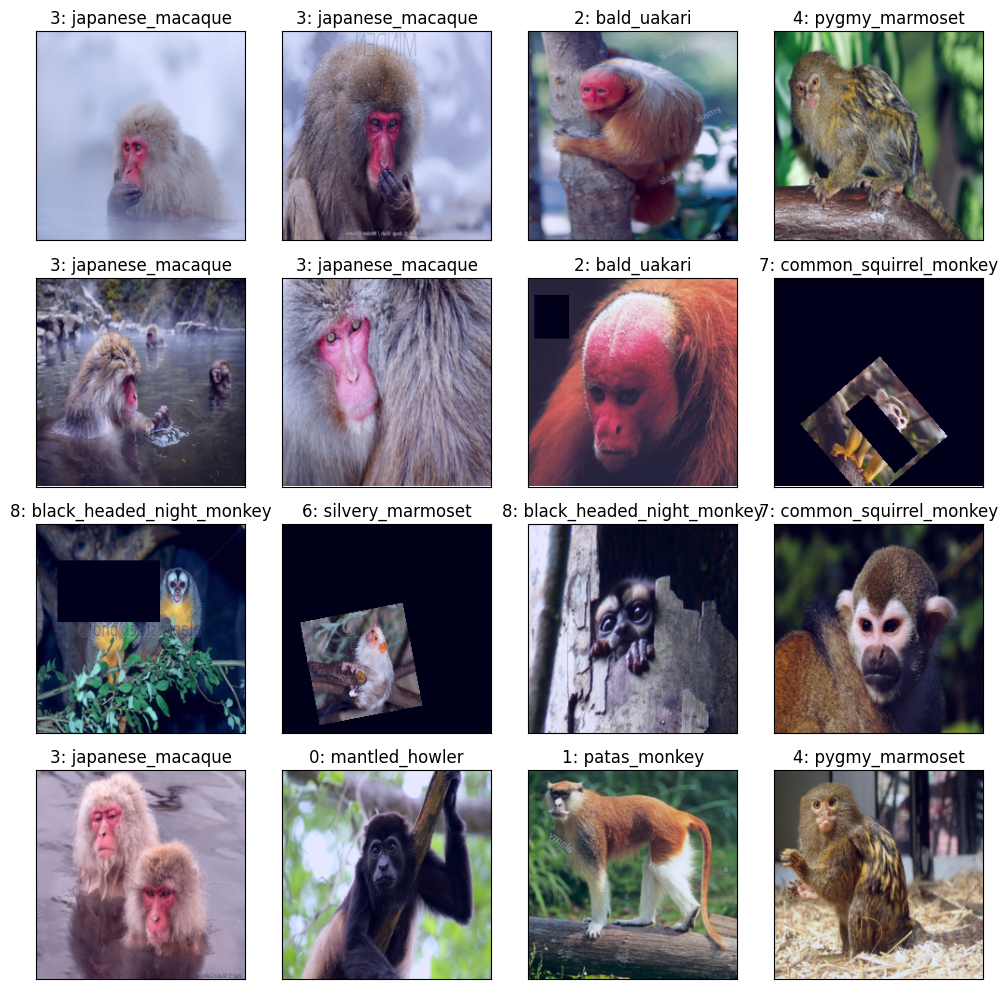

32


In [12]:
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #Iterate over the first batch
    images, labels = next(iter(dataloader))
    # print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]


        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0)

        #Normalize the image to [0,1] to display

        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # remove the batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()
    print(len(images))

visualize_images(train_loader, num_images = 16)

In [13]:
class CNNMod(nn.Module):
    def __init__(self):
        super().__init__()

        self._model = nn.Sequential(

            nn.Conv2d(in_channels=3,out_channels =32,kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),


            nn.Conv2d(in_channels=32,out_channels =32,kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace =True),
            nn.MaxPool2d(kernel_size =2),

            
            #block 2: 64,128 filters, maxpool, droput(p=0.25) 
            
            nn.LazyConv2d(out_channels =64,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),


            nn.LazyConv2d(out_channels =128,kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace =True),
            nn.MaxPool2d(kernel_size =2),

            #block 3 : cond2d with activation block 3: 128,256,512 filters, maxpool

            Conv2dNormActivation(in_channels = 128,out_channels=256,kernel_size = 3),
            nn.MaxPool2d(kernel_size= 2),

            Conv2dNormActivation(in_channels = 256,out_channels=512,kernel_size = 3),
            nn.MaxPool2d(kernel_size= 2),

            # feed forward layers

            nn.AdaptiveAvgPool2d(output_size=(3,3)),

            # flatten the convolutional features

            nn.Flatten(),

            nn.Linear(in_features = 512*3*3,out_features=256),
            nn.Linear(in_features = 256, out_features =10)
)

    def forward(self,x):
        return self._model(x)      

In [14]:
model = CNNMod()

optimizer  = Adam(model.parameters(), lr = train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

logdir = "runs/80epochs-3.3M_param_dropout"

writer = SummaryWriter(logdir)

dummy_input = (1,3,224,224)
print(summary(model, dummy_input, row_settings = ["var_names"],device=DEVICE))

Layer (type (var_name))                  Output Shape              Param #
CNNMod (CNNMod)                          [1, 10]                   --
├─Sequential (_model)                    [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 32, 218, 218]         9,248
│    └─BatchNorm2d (4)                   [1, 32, 218, 218]         64
│    └─ReLU (5)                          [1, 32, 218, 218]         --
│    └─MaxPool2d (6)                     [1, 32, 109, 109]         --
│    └─Conv2d (7)                        [1, 64, 107, 107]         18,496
│    └─BatchNorm2d (8)                   [1, 64, 107, 107]         128
│    └─ReLU (9)                          [1, 64, 107, 107]         --
│    └─Conv2d (10)                       [1, 128, 105, 105]        73,856


Model Training and Validation

In [15]:
def train(model,train_loader):
    model.train()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images,labels in tqdm(train_loader, desc="Training"):
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted = torch.max(outputs.data,dim=1)
        total_train_samples+=labels.shape[0]
        correct_predictions+=(predicted==labels).sum().item()

    train_avg_loss = running_loss/len(train_loader)
    train_accuracy = 100*correct_predictions/total_train_samples
    return train_avg_loss, train_accuracy    

In [16]:
def val(model,val_loader):
    model.eval()
    model.to(DEVICE)

    for images,labels in tqdm(val_loader,desc ="Validation"):
        images,labels = images.to(DEVICE),labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(images)
            loss= F.cross_entropy(outputs,labels)
            running_loss+=loss.item()
            _,predicted = torch.max(outputs.data,dim=1)
            total_val_samples+=labels.shape[0]
            correct_predictions+=(predicted ==labels).sum().item()

        val_avg_loss = running_loss/len(val_loader)
        val_accuracy = 100*correct_predictions/total_val_samples

        return     val_avg_loss,val_accuracy



In [17]:
def main(model,train_loader,val_loader):

    train_losses,val_losses = [], []
    train_accuracies, val_accuracies = [],[]

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(train_config.num_epochs):

        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = train(model, val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

    return train_losses, train_accuracies, val_losses, val_accuracies



In [18]:

train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)


Training: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 01/20 - Train Loss: 2.0016, Train Accuracy: 28.08% - Val Loss: 2.7503, Val Accuracy: 15.44%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 02/20 - Train Loss: 1.6341, Train Accuracy: 43.30% - Val Loss: 2.2360, Val Accuracy: 28.68%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 03/20 - Train Loss: 1.4499, Train Accuracy: 49.23% - Val Loss: 2.0732, Val Accuracy: 28.68%


Training: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 04/20 - Train Loss: 1.3465, Train Accuracy: 52.60% - Val Loss: 1.9011, Val Accuracy: 32.72%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 05/20 - Train Loss: 1.2403, Train Accuracy: 56.97% - Val Loss: 1.7659, Val Accuracy: 38.24%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 06/20 - Train Loss: 1.1868, Train Accuracy: 58.16% - Val Loss: 1.5496, Val Accuracy: 44.49%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 07/20 - Train Loss: 1.1702, Train Accuracy: 58.07% - Val Loss: 1.4740, Val Accuracy: 49.26%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


Epoch 08/20 - Train Loss: 1.1135, Train Accuracy: 61.17% - Val Loss: 1.4333, Val Accuracy: 50.37%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 09/20 - Train Loss: 1.0605, Train Accuracy: 63.45% - Val Loss: 1.3405, Val Accuracy: 52.57%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 10/20 - Train Loss: 1.0674, Train Accuracy: 61.26% - Val Loss: 1.1807, Val Accuracy: 57.35%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 11/20 - Train Loss: 0.9748, Train Accuracy: 67.73% - Val Loss: 1.1156, Val Accuracy: 61.76%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 12/20 - Train Loss: 0.9648, Train Accuracy: 66.00% - Val Loss: 1.0307, Val Accuracy: 64.71%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 13/20 - Train Loss: 0.9120, Train Accuracy: 69.46% - Val Loss: 0.9660, Val Accuracy: 67.65%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 14/20 - Train Loss: 0.8486, Train Accuracy: 71.10% - Val Loss: 0.9023, Val Accuracy: 70.22%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 15/20 - Train Loss: 0.8899, Train Accuracy: 69.55% - Val Loss: 0.8444, Val Accuracy: 74.26%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 16/20 - Train Loss: 0.8627, Train Accuracy: 71.29% - Val Loss: 0.7994, Val Accuracy: 73.16%


Training: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 17/20 - Train Loss: 0.7973, Train Accuracy: 72.84% - Val Loss: 0.7285, Val Accuracy: 77.94%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 18/20 - Train Loss: 0.8182, Train Accuracy: 72.01% - Val Loss: 0.6489, Val Accuracy: 80.15%
Saving best model...💾


Training: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 19/20 - Train Loss: 0.8033, Train Accuracy: 72.38% - Val Loss: 0.6526, Val Accuracy: 79.04%


Training: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

Epoch 20/20 - Train Loss: 0.8315, Train Accuracy: 73.56% - Val Loss: 0.6649, Val Accuracy: 77.57%


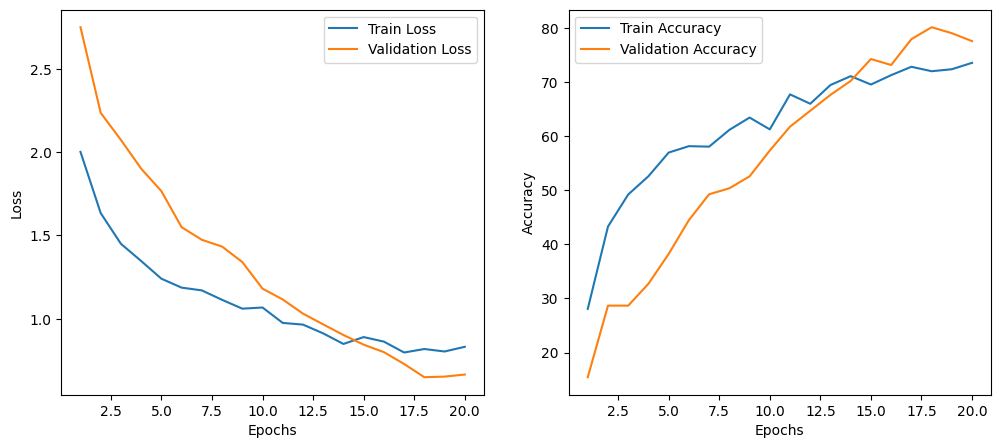

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,train_config.num_epochs + 1), train_losses, label = "Train Loss")
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,train_config.num_epochs + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
def prediction(model, val_loader):

    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
             outputs = model(images)

        prob = F.softmax(outputs,dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())


    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())

In [21]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar + mean_ar
    return np.clip(image, 0,1)

In [22]:
def visualise_predictions(sample_images,sample_gt_labels, pred_indices, pred_probs, num_images =5):

    fig = plt.figure(figsize = (20,5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) -1)
        image = sample_images[idx].transpose(1,2,0) #(C,H,W) --> (H,W,C)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()

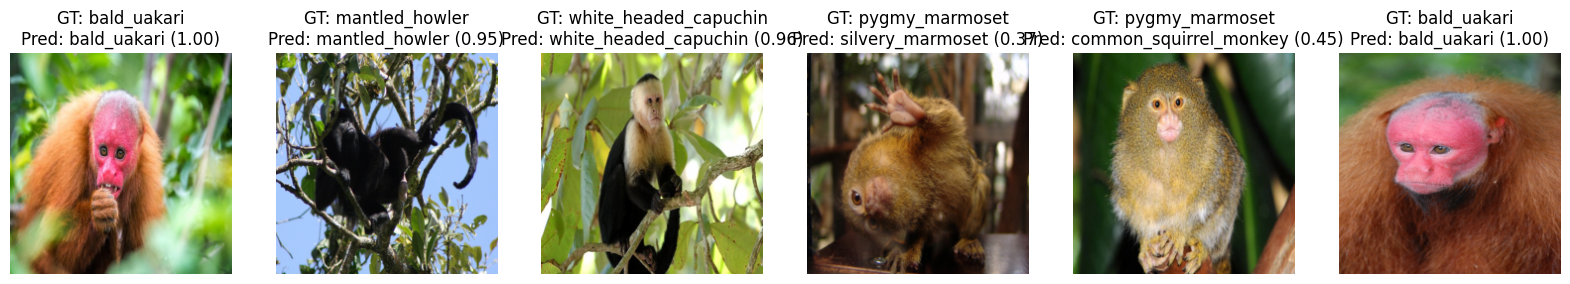

In [23]:
sample_images,sample_gt_labels, pred_indices, all_pred_probs = prediction(model,val_loader)
visualise_predictions(sample_images,sample_gt_labels, pred_indices, all_pred_probs,num_images=6)